In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, MaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
import pickle
import json

### ResNet

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import tensorflow as tf

# ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,   
    height_shift_range=0.2,  
    shear_range=0.2,         
    zoom_range=0.2,          
    fill_mode='nearest',
    validation_split=0.2,  
)

input_shape = (224, 224, 3)  

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-10:]:
    layer.trainable = True


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(36, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Load your training data using ImageDataGenerator
train_generator = datagen.flow_from_directory(
    'output-train-by-char',   
    target_size=(224, 224),
    color_mode='rgb',     
    batch_size=32,              
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    'output-train-by-char',
    target_size=(224, 224),
    color_mode='rgb',      
    batch_size=32,               
    class_mode='categorical',   
    subset='validation'           
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_resnet-50-unfreeze.keras', 
    monitor='val_loss',  
    save_best_only=True,  
    mode='min',           
    verbose=1            
)



Found 33724 images belonging to 36 classes.
Found 8412 images belonging to 36 classes.


In [4]:
def plot_graphs(history):
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    train_loss = history['loss']
    val_loss = history['val_loss']

    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

#### Res-Net 50 unfreeze

In [6]:
model_unfreeze = load_model('best_model_resnet-50-unfreeze.keras')
with open('history_resnet50-unfreeze.pkl', 'rb') as f:
    history_unfreeze = pickle.load(f)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'output-test',
    target_size=(24, 24),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
# y_preds = model_unfreeze.predict(test_generator)

Found 9021 images belonging to 36 classes.


In [14]:
classification_report_unfreeze = classification_report(test_generator.classes, np.argmax(y_preds, axis=1), target_names=test_generator.class_indices.keys())
print(classification_report_unfreeze)

              precision    recall  f1-score   support

           0       0.51      0.58      0.54       258
           1       0.64      0.64      0.64       234
           2       0.81      0.89      0.85       249
           3       0.94      0.81      0.87       227
           4       0.89      0.89      0.89       235
           5       0.87      0.72      0.79       238
           6       0.86      0.82      0.84       224
           7       0.97      0.80      0.88       233
           8       0.74      0.84      0.79       253
           9       0.89      0.65      0.75       268
           a       0.90      0.73      0.81       268
           b       0.93      0.71      0.80       255
           c       0.82      0.87      0.84       256
           d       0.89      0.80      0.84       270
           e       0.87      0.85      0.86       237
           f       0.96      0.82      0.89       221
           g       0.69      0.79      0.74       243
           h       0.89    

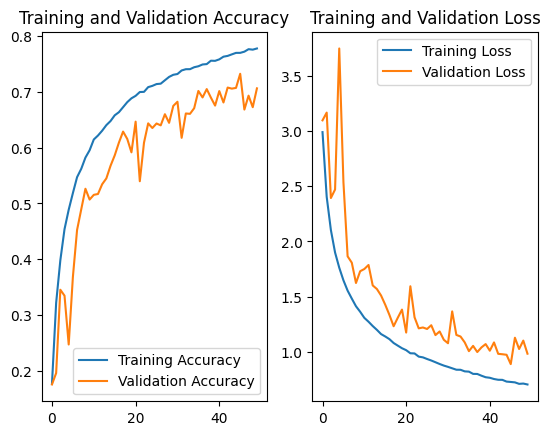

In [23]:
plot_graphs(history_unfreeze)

the curves generally look ok, but the val acc and val loss is rather jagged, mb will try to inc the the batch size and lower the lr slightly, inc the number of epochs (since it didnt start plateuing yet), add a dropout layer to head (curves diverge so there is overfitting), generally the model recognises most of the character but it has trouble predicting 0 and O which is understable bcs they look very similar, currently using the split fn but looks like train set doesnt capture it? 

looked at val generator classes, no intersection and is well-represented to this is probably overfitting
abit unstable so dec the lr and dec the amt of augmentation

In [ ]:
# exploring the splits to see if the val is well-represented
datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2,
)

# Load your training data using ImageDataGenerator
train_generator = datagen.flow_from_directory(
    'output-train-by-char',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True)

val_generator = datagen.flow_from_directory(
    'output-train-by-char',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

val_files = val_generator.filepaths
train_files = train_generator.filepaths

Found 33724 images belonging to 36 classes.
Found 8412 images belonging to 36 classes.


(24, 24, 3)
(24, 24, 3)
(24, 24, 3)
(24, 24, 3)
(24, 24, 3)
(24, 24, 3)
(24, 24, 3)
(24, 24, 3)
(24, 24, 3)
(24, 24, 3)


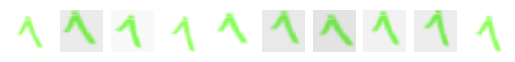

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Function to pad the image and resize it to 224x224
def pad_image(img):
    target_size=(24, 24)
    h, w, _ = img.shape
    
    pad_h = max(0, target_size[0] - h)
    pad_w = max(0, target_size[1] - w)
    
    if pad_h > 0 or pad_w > 0:
        top_pad = pad_h // 2
        bottom_pad = pad_h - top_pad
        left_pad = pad_w // 2
        right_pad = pad_w - left_pad
        
        img = np.pad(
            img, 
            ((top_pad, bottom_pad), 
             (left_pad, right_pad), 
             (0, 0)), 
            mode='constant', 
            constant_values=0
        )
    
    if img.shape[0] != target_size[0] or img.shape[1] != target_size[1]:
        img = cv2.resize(img, target_size)
    
    return img

# ImageDataGenerator setup with custom padding function
datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.08,  
        height_shift_range=0.08,
        zoom_range=0.12,  
        shear_range=0.08,  
        brightness_range=[0.85, 1.15],  
        fill_mode='nearest',  
        validation_split=0.2
    )

# Ensure the input image shape matches the target size
img_path = './output-train-by-char/1/0a1gfi-0-2.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
x = cv2.resize(img, (24, 24))
x = np.expand_dims(x, axis=0) 

# Preview augmented images
i = 0
for batch in datagen.flow(x, batch_size=1):
    i += 1
    if i > 10:
        break
    augmented_image = batch[0]
    print(augmented_image.shape)  
    plt.subplot(1, 10, i)  
    plt.imshow(augmented_image)
    plt.axis('off')

plt.show()

#### resnet50 - 20 layer unfreeze, batch size 16, 5e-5 lr 

In [69]:
model_20_unfreeze = load_model('resnet50_model-unfreeze-20-backup-rd2.keras')
with open('history_resnet50-unfreeze-20-rd2.pkl', 'rb') as f:
    history_20_unfreeze = pickle.load(f)

In [70]:
y_preds_20_unfreeze = model_20_unfreeze.predict(test_generator)
classification_report_20_unfreeze = classification_report(test_generator.classes, np.argmax(y_preds_20_unfreeze, axis=1), target_names=test_generator.class_indices.keys())
print(classification_report_20_unfreeze)

282/282 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step
              precision    recall  f1-score   support

           0       0.52      0.61      0.56       258
           1       0.73      0.61      0.66       234
           2       0.83      0.87      0.85       249
           3       0.89      0.93      0.91       227
           4       0.87      0.92      0.89       235
           5       0.85      0.81      0.83       238
           6       0.90      0.88      0.89       224
           7       0.86      0.92      0.89       233
           8       0.83      0.82      0.83       253
           9       0.75      0.88      0.81       268
           a       0.90      0.74      0.81       268
           b       0.80      0.87      0.83       255
           c       0.90      0.86      0.88       256
           d       0.80      0.86      0.83       270
           e       0.81      0.91      0.86       237
           f       0.75      0.90      0.82       221
           g       0.85      0.74      

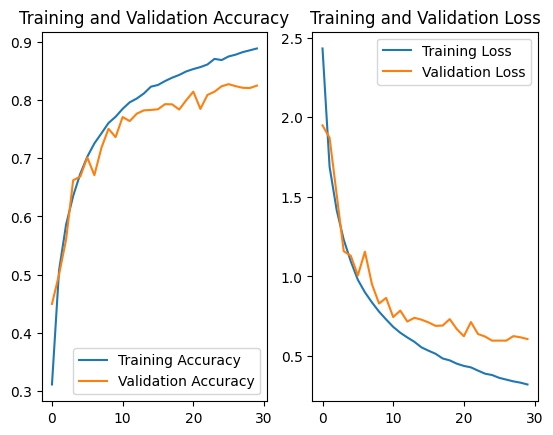

In [71]:
plot_graphs(history_20_unfreeze)

### Small ResNet

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def pad_image(img):
    target_size = (24, 24)

    # Get image dimensions
    h, w, _ = img.shape

    # Calculate padding for height and width
    pad_h = max(0, target_size[0] - h)
    pad_w = max(0, target_size[1] - w)

    if pad_h > 0 or pad_w > 0:
        # Calculate padding for each side
        top_pad = pad_h // 2
        bottom_pad = pad_h - top_pad
        left_pad = pad_w // 2
        right_pad = pad_w - left_pad

        # Pad the image
        img = np.pad(
            img,
            ((top_pad, bottom_pad),
             (left_pad, right_pad),
             (0, 0)),
            mode='constant',
            constant_values=0
        )

    # Resize if needed
    if img.shape[0] != target_size[0] or img.shape[1] != target_size[1]:
        img = cv2.resize(img, target_size)

    return img

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=pad_image)



test_generator = test_datagen.flow_from_directory(
    'output-test',
    target_size=(24, 24),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 9021 images belonging to 36 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Residual Block
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_model(input_shape=(224, 224, 3), num_classes=36, dropout_rate=0.3):
    input_tensor = Input(shape=input_shape)

    # Initial Convolutional Layer
    x = Conv2D(64, (3, 3), padding='same', strides=1)(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Stack 5 residual blocks
    for _ in range(5):
        x = residual_block(x, 64)  
        x = Dropout(dropout_rate)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

# Build the model
model = build_model(input_shape, num_classes=36)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=val_generator, epochs=10)


In [7]:
model_resnet_own = load_model('resnet50_model-5-backup-rd2.keras')

with open('history_resnet50-5-rd2.pkl', 'rb') as f:
    history_resnet_own = pickle.load(f)

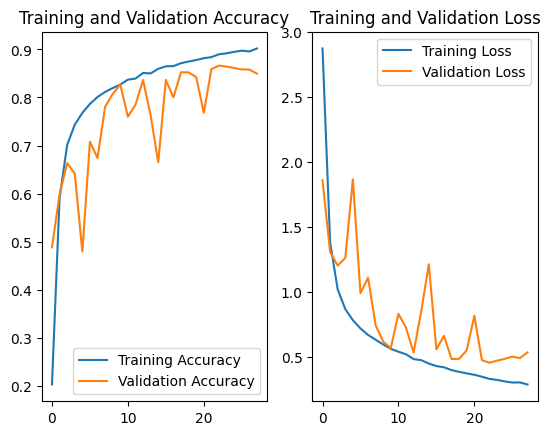

In [9]:
plot_graphs(history_resnet_own)

In [14]:
y_preds_resnet_own = model_resnet_own.predict(test_generator)
classification_report_resnet_own = classification_report(test_generator.classes, np.argmax(y_preds_resnet_own, axis=1), target_names=test_generator.class_indices.keys())
print(classification_report_resnet_own)

c:\Users\spooj\Downloads\cv-project\env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


282/282 ━━━━━━━━━━━━━━━━━━━━ 141s 491ms/step
              precision    recall  f1-score   support

           0       0.56      0.54      0.55       258
           1       0.62      0.60      0.61       234
           2       0.90      0.88      0.89       249
           3       0.90      0.95      0.92       227
           4       0.91      0.91      0.91       235
           5       0.75      0.89      0.81       238
           6       0.95      0.90      0.92       224
           7       0.86      0.88      0.87       233
           8       0.92      0.86      0.89       253
           9       0.88      0.82      0.85       268
           a       0.91      0.83      0.87       268
           b       0.78      0.92      0.84       255
           c       0.93      0.86      0.89       256
           d       0.80      0.90      0.85       270
           e       0.92      0.94      0.93       237
           f       0.92      0.93      0.92       221
           g       0.84      0.86   

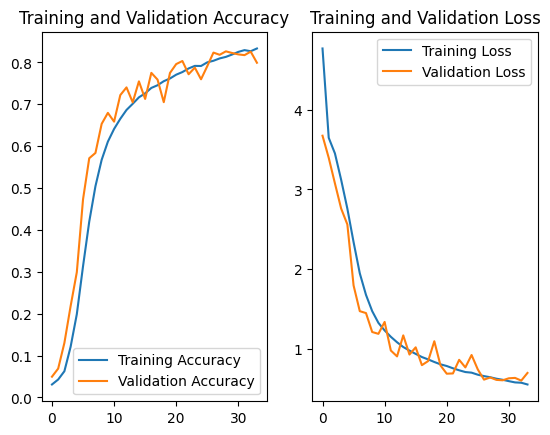

In [20]:
with open('history_resnet50-5-rd3.pkl', 'rb') as f:
    history_resnet_own = pickle.load(f)

plot_graphs(history_resnet_own)

In [21]:
model_resnet_own = load_model('resnet50_model-5-backup-rd3.keras')
y_preds_resnet_own = model_resnet_own.predict(test_generator)
classification_report_resnet_own = classification_report(test_generator.classes, np.argmax(y_preds_resnet_own, axis=1), target_names=test_generator.class_indices.keys())

282/282 ━━━━━━━━━━━━━━━━━━━━ 208s 735ms/step


In [22]:
print(classification_report_resnet_own)

              precision    recall  f1-score   support

           0       0.48      0.57      0.52       258
           1       0.53      0.70      0.60       234
           2       0.90      0.85      0.87       249
           3       0.95      0.93      0.94       227
           4       0.80      0.89      0.84       235
           5       0.75      0.85      0.79       238
           6       0.89      0.92      0.90       224
           7       0.89      0.81      0.85       233
           8       0.88      0.82      0.85       253
           9       0.87      0.82      0.84       268
           a       0.77      0.81      0.79       268
           b       0.82      0.84      0.83       255
           c       0.94      0.88      0.91       256
           d       0.78      0.88      0.83       270
           e       0.86      0.89      0.88       237
           f       0.88      0.88      0.88       221
           g       0.87      0.77      0.81       243
           h       0.86    

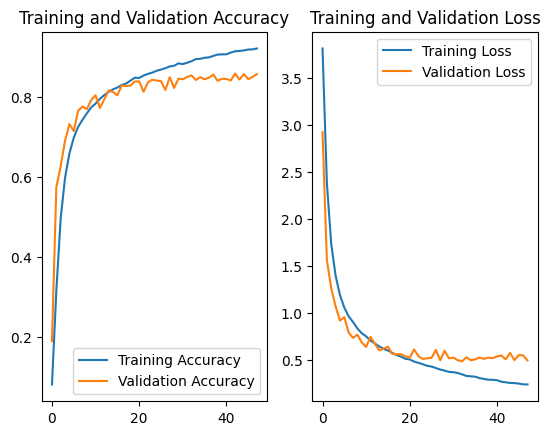

In [44]:
model_rd4 = load_model('resnet50_model-5-backup-rd4.keras')
with open('history_resnet50-5-rd4.pkl', 'rb') as f:
    history_resnet_own = pickle.load(f)
plot_graphs(history_resnet_own)

### CNN + Transformer

In [16]:
model_cnn_transformer = load_model('cnn_transformer-rd2.keras')
with open('history_cnn-transformer-rd2.pkl', 'rb') as f:
    history_cnn_transformer = pickle.load(f)



In [ ]:
y_preds_cnn_transformer = model_cnn_transformer.predict(test_generator)
classification_report_cnn_transformer = classification_report(test_generator.classes, np.argmax(y_preds_cnn_transformer, axis=1), target_names=test_generator.class_indices.keys())

In [19]:
print(classification_report_cnn_transformer)

              precision    recall  f1-score   support

           0       0.47      0.68      0.56       258
           1       0.65      0.58      0.61       234
           2       0.87      0.85      0.86       249
           3       0.95      0.85      0.90       227
           4       0.84      0.85      0.84       235
           5       0.85      0.78      0.81       238
           6       0.80      0.87      0.83       224
           7       0.81      0.89      0.84       233
           8       0.70      0.82      0.75       253
           9       0.85      0.75      0.80       268
           a       0.84      0.71      0.77       268
           b       0.82      0.84      0.83       255
           c       0.94      0.86      0.90       256
           d       0.89      0.84      0.86       270
           e       0.95      0.83      0.88       237
           f       0.90      0.86      0.88       221
           g       0.81      0.68      0.74       243
           h       0.81    

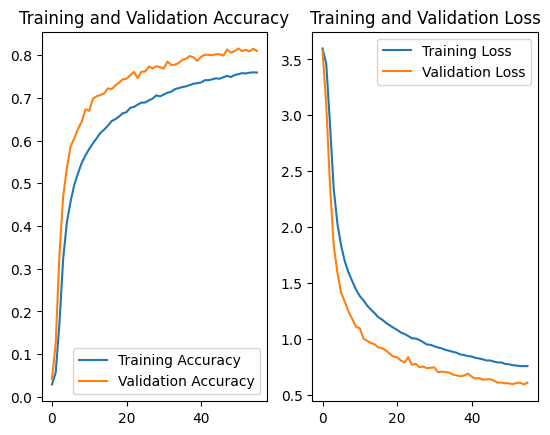

In [18]:
plot_graphs(history_cnn_transformer)

In [17]:
# cnn-transformer rd 2 with residual blocks
model_cnn_rd3 = load_model('cnn_transformer-rd3.keras')
with open('history_cnn-transformer-rd3.pkl', 'rb') as f:
    history_cnn_transformer_rd3 = pickle.load(f)

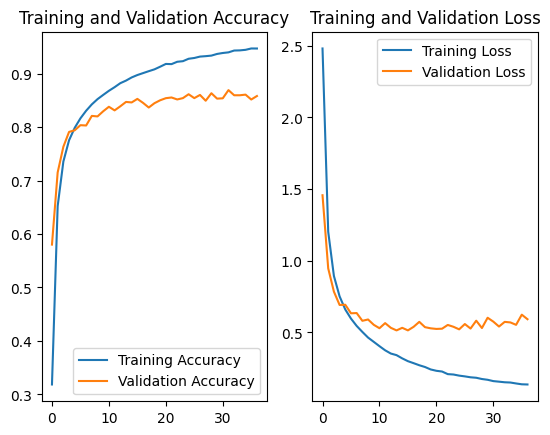

In [20]:
plot_graphs(history_cnn_transformer_rd3)

In [26]:
y_preds = model_cnn_rd3.predict(test_generator)
classification_report_cnn_transformer_rd3 = classification_report(test_generator.classes, np.argmax(y_preds, axis=1), target_names=test_generator.class_indices.keys())
print(classification_report_cnn_transformer_rd3)

c:\Users\spooj\Downloads\cv-project\env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


282/282 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       258
           1       0.69      0.62      0.65       234
           2       0.87      0.88      0.88       249
           3       0.96      0.93      0.94       227
           4       0.92      0.82      0.87       235
           5       0.91      0.80      0.85       238
           6       0.98      0.88      0.92       224
           7       0.89      0.91      0.90       233
           8       0.83      0.90      0.86       253
           9       0.89      0.85      0.87       268
           a       0.92      0.81      0.86       268
           b       0.86      0.88      0.87       255
           c       0.94      0.91      0.92       256
           d       0.89      0.88      0.89       270
           e       0.90      0.92      0.91       237
           f       0.77      0.93      0.84       221
           g       0.86      0.85     

In [29]:
transformer_rd4 = load_model('cnn_transformer-rd4.keras')
with open('history_cnn-transformer-rd4.pkl', 'rb') as f:
    history_cnn_transformer_rd4 = pickle.load(f)


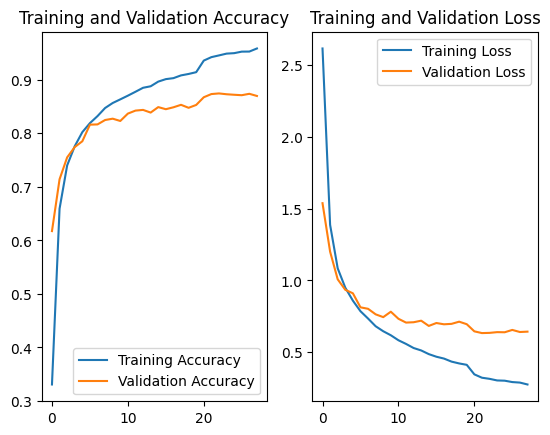

In [28]:
plot_graphs(history_cnn_transformer_rd4)

In [30]:
y_preds_rd4 = transformer_rd4.predict(test_generator)
classification_report_cnn_transformer_rd4 = classification_report(test_generator.classes, np.argmax(y_preds_rd4, axis=1), target_names=test_generator.class_indices.keys())
print(classification_report_cnn_transformer_rd4)


282/282 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step
              precision    recall  f1-score   support

           0       0.53      0.60      0.56       258
           1       0.59      0.65      0.62       234
           2       0.90      0.90      0.90       249
           3       0.93      0.91      0.92       227
           4       0.92      0.89      0.90       235
           5       0.89      0.87      0.88       238
           6       0.92      0.92      0.92       224
           7       0.90      0.88      0.89       233
           8       0.89      0.90      0.90       253
           9       0.92      0.85      0.88       268
           a       0.88      0.87      0.87       268
           b       0.92      0.87      0.90       255
           c       0.97      0.88      0.92       256
           d       0.89      0.90      0.89       270
           e       0.91      0.93      0.92       237
           f       0.84      0.94      0.89       221
           g       0.86      0.86    

In [2]:
model_rd5 = load_model('cnn_transformer-rd5.keras')
with open('history_cnn-transformer-rd5.pkl', 'rb') as f:
    history_cnn_transformer_rd5 = pickle.load(f)

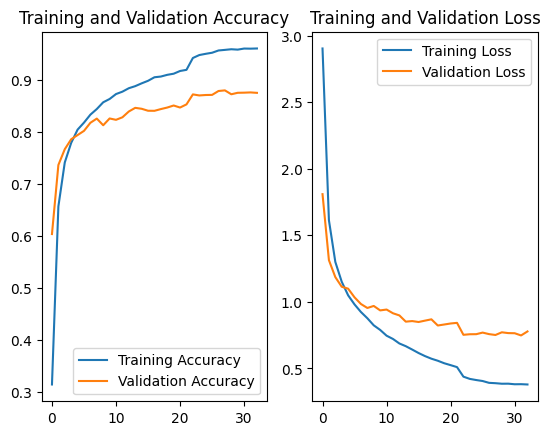

In [5]:
plot_graphs(history_cnn_transformer_rd5)

In [8]:
y_preds_rd5 = model_rd5.predict(test_generator)
classification_report_cnn_transformer_rd5 = classification_report(test_generator.classes, np.argmax(y_preds_rd5, axis=1), target_names=test_generator.class_indices.keys())
print(classification_report_cnn_transformer_rd5)


c:\Users\spooj\Downloads\cv-project\env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


282/282 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step
              precision    recall  f1-score   support

           0       0.53      0.62      0.57       258
           1       0.69      0.62      0.65       234
           2       0.91      0.90      0.90       249
           3       0.97      0.90      0.93       227
           4       0.90      0.92      0.91       235
           5       0.89      0.86      0.87       238
           6       0.92      0.93      0.92       224
           7       0.90      0.90      0.90       233
           8       0.85      0.89      0.87       253
           9       0.89      0.84      0.86       268
           a       0.90      0.85      0.88       268
           b       0.89      0.90      0.90       255
           c       0.97      0.88      0.93       256
           d       0.89      0.89      0.89       270
           e       0.91      0.92      0.92       237
           f       0.72      0.94      0.82       221
           g       0.87      0.84    

### Res-Net 50 

In [20]:
model_head = load_model('best_model_resnet-50.keras')
history_head = json.load(open('history_resnet50.json', 'r'))

y_preds_head = model_head.predict(test_generator)

282/282 ━━━━━━━━━━━━━━━━━━━━ 616s 2s/step


In [21]:
classification_report_head = classification_report(test_generator.classes, np.argmax(y_preds_head, axis=1), target_names=test_generator.class_indices.keys())
print(classification_report_head)

              precision    recall  f1-score   support

           0       0.23      0.43      0.30       258
           1       0.19      0.15      0.17       234
           2       0.30      0.17      0.22       249
           3       0.45      0.35      0.40       227
           4       0.65      0.14      0.24       235
           5       0.58      0.24      0.33       238
           6       0.43      0.12      0.18       224
           7       0.52      0.58      0.55       233
           8       0.25      0.09      0.13       253
           9       0.62      0.06      0.11       268
           a       0.23      0.02      0.04       268
           b       0.31      0.04      0.08       255
           c       0.31      0.51      0.39       256
           d       0.46      0.04      0.08       270
           e       0.35      0.31      0.33       237
           f       0.54      0.38      0.45       221
           g       0.22      0.05      0.08       243
           h       0.67    

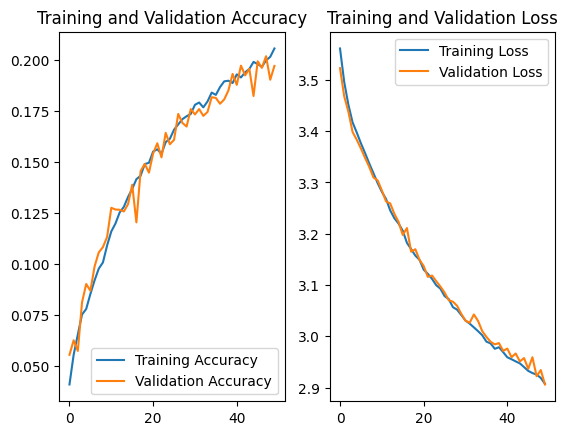

In [24]:
plot_graphs(history_head)